In [ ]:
# Install Library
!pip install librosa

In [ ]:
# Import Library
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf

# audio plot
from scipy.io import wavfile as wav
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [ ]:
# !unzip '/content/Dataset.zip' -d './dataset'

In [ ]:
# Create Dataset Path
dataset_path = '/content/dataset/train'

In [ ]:
# Gathering Data
dataset = list(glob.glob(dataset_path + '/**/*.wav'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], dataset))
file_path = pd.Series(dataset, name = 'File_Path').astype(str)
labels = pd.Series(labels, name = 'Labels')
data = pd.concat([file_path, labels], axis = 1)
data = data.sample(frac = 1).reset_index(drop = True)
data.head()

,File_Path,Labels
0,/content/dataset/train/cat/cat_40.wav,cat
1,/content/dataset/train/cat/cat_121.wav,cat
2,/content/dataset/train/cat/cat_71.wav,cat
3,/content/dataset/train/cat/cat_159.wav,cat
4,/content/dataset/train/cat/cat_141.wav,cat


# Explanatory Data Analysis (EDA) and Visualization

In [ ]:
# Show Data
data.head()

,File_Path,Labels
0,/content/dataset/train/cat/cat_40.wav,cat
1,/content/dataset/train/cat/cat_121.wav,cat
2,/content/dataset/train/cat/cat_71.wav,cat
3,/content/dataset/train/cat/cat_159.wav,cat
4,/content/dataset/train/cat/cat_141.wav,cat


TOTAL SAMPLE OF EACH CLASS
cat    125
dog     85
Name: Labels, dtype: int64


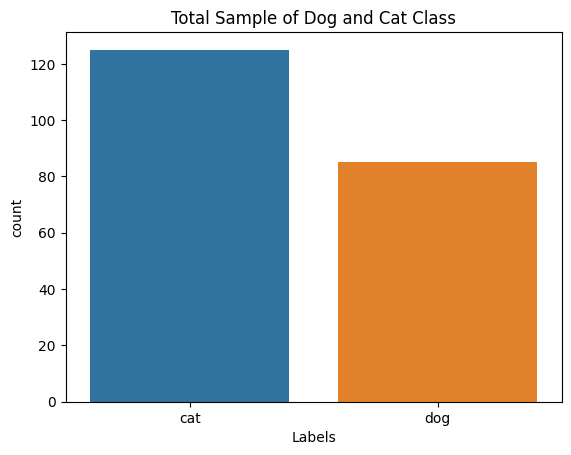

In [ ]:
# Show Total Sample of Each Class
print('TOTAL SAMPLE OF EACH CLASS')
print(data['Labels'].value_counts())
sns.countplot(x = 'Labels', data = data)
plt.title('Total Sample of Dog and Cat Class')
plt.show()

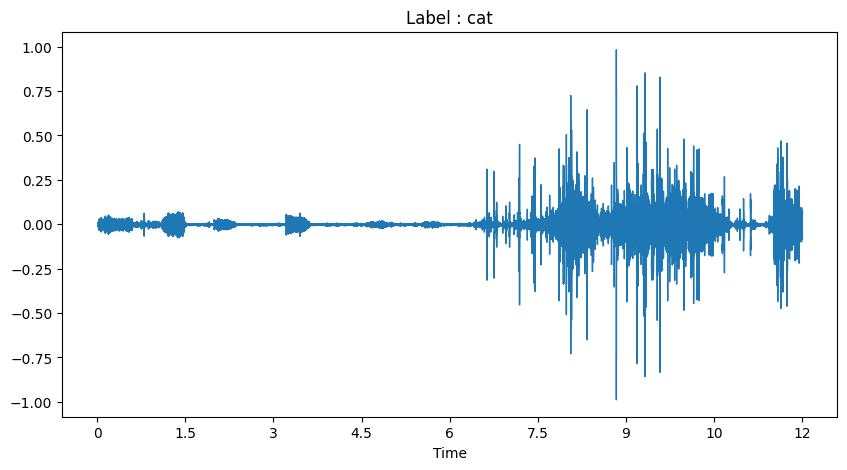

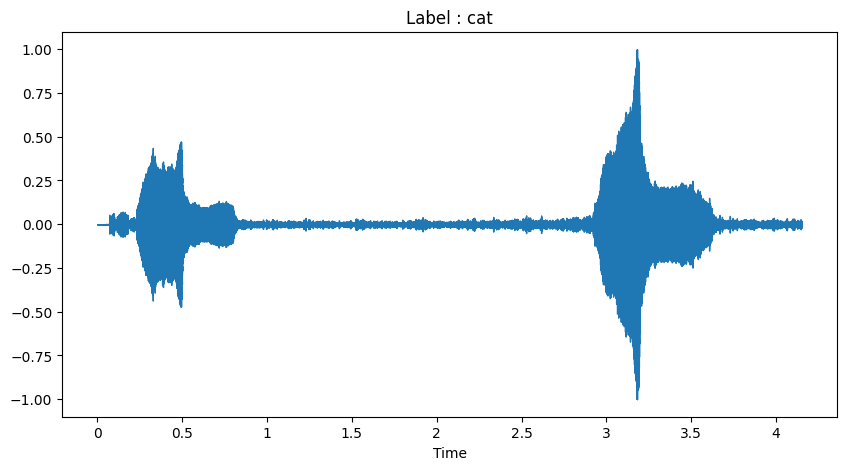

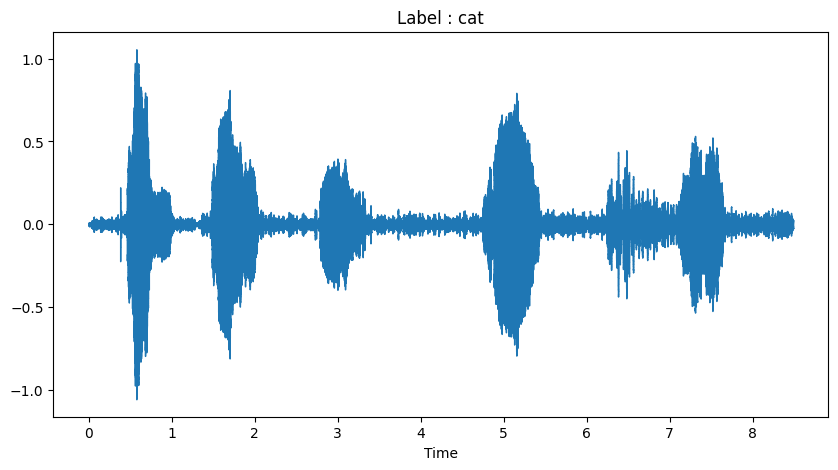

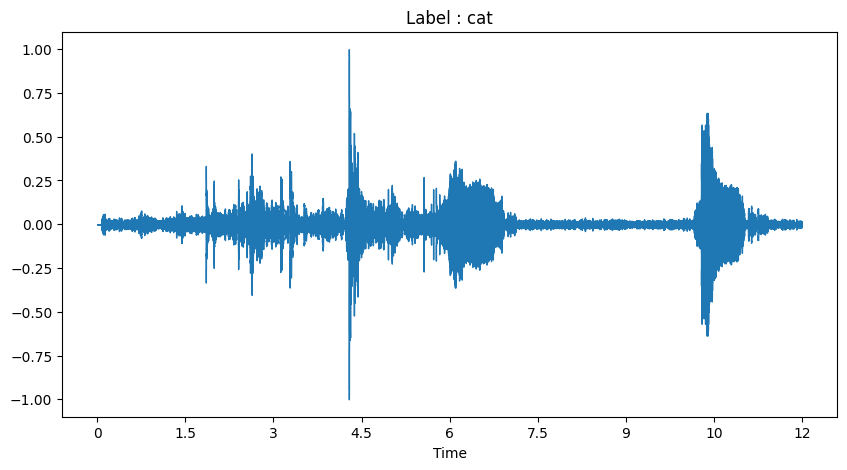

In [ ]:
# Show Waveform from Data
for i in range(4):
    x, sr = librosa.load(data.File_Path[i])
    plt.figure(figsize = (10, 5))
    plt.title('Label : ' + str(data['Labels'][i]))
    librosa.display.waveshow(x, sr = sr)

In [ ]:
# Display Audio
ipd.Audio(data.File_Path[1])

In [ ]:
# Display Audio
ipd.Audio(data.File_Path[4])

# Data Preprocessing

Feature Extraction - MFCC

In [ ]:
def feature_extract(file_name):
    audio, sr = librosa.load(file_name, res_type='soxr_vhq')
    mfccs = librosa.feature.mfcc(y = audio, sr = sr, n_mfcc = 40)
    mfccs_processed = np.mean(mfccs.T, axis = 0)
    return mfccs_processed

In [ ]:
features = []

for index, row in data.iterrows():
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = feature_extract(file_name)
    features.append([data_, class_label])

In [ ]:
features_df = pd.DataFrame(features, columns = ['Feature', 'Class_Label'])
features_df.head()

,Feature,Class_Label
0,"[-376.72675, 116.234634, -42.698593, 34.21151,...",cat
1,"[-298.45386, 113.16799, -5.1134386, 3.3969672,...",cat
2,"[-269.3691, 94.08974, -22.488415, 40.61075, -4...",cat
3,"[-280.97104, 95.579346, -10.40177, 37.569565, ...",cat
4,"[-128.28181, 81.45043, -130.18071, 49.186626, ...",cat


Separate Variable

In [ ]:
x = np.array(features_df.Feature.tolist())
y = np.array(features_df.Class_Label.tolist())

Label Encoder

In [ ]:
label = LabelEncoder()
y = to_categorical(label.fit_transform(y))

Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

# Modelling Using Feed Forward

Build Model

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim = 40,  activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               5248      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 2)                

Training Model

In [ ]:
# earlystop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs = 100,
    batch_size = 64
)

Epoch 1/100
3/3 [==============================] - 3s 18ms/step - loss: 13.2333 - accuracy: 0.5298
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 7.7381 - accuracy: 0.6607
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 5.9604 - accuracy: 0.6905
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 6.5516 - accuracy: 0.6429
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 5.5935 - accuracy: 0.7143
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 4.0087 - accuracy: 0.6845
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 4.4777 - accuracy: 0.6667
Epoch 8/100
3/3 [==============================] - 0s 10ms/step - loss: 3.9288 - accuracy: 0.7440
Epoch 9/100
3/3 [==============================] - 0s 19ms/step - loss: 3.2328 - accuracy: 0.7202
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 2.9568 - accuracy: 0.7202
Epoch 11/100
3/3 [==

# Evaluation Model

In [ ]:
score = model.evaluate(x_train, y_train, verbose = 0)
print("Training Model Accuracy : \033[01m {0:.2%}\033[0m".format(score[1]))

Training Model Accuracy :  91.07%


# Prediction

In [ ]:
# Create Dataset Path
testset_path = '/content/dataset/train'

In [ ]:
testset = list(glob.glob(testset_path + '/**/*.wav'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], testset))
file_path = pd.Series(dataset, name = 'File_Path').astype(str)
labels = pd.Series(labels, name = 'Labels')
data = pd.concat([file_path, labels], axis = 1)
data = data.sample(frac = 1).reset_index(drop = True)
data.head()

,File_Path,Labels
0,/content/dataset/train/dog/dog_barking_1.wav,dog
1,/content/dataset/train/cat/cat_138.wav,cat
2,/content/dataset/train/dog/dog_barking_29.wav,dog
3,/content/dataset/train/cat/cat_125.wav,cat
4,/content/dataset/train/dog/dog_barking_88.wav,dog


In [ ]:
def prediction(path_sound):
    data_sound = feature_extract(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1, 40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_, axis = 1)
    pred_class = label.inverse_transform(pred_)
    print("The predicted class : \033[01m ", pred_class[0],'\033[0m \n')

In [ ]:
path_sound = '/content/dataset/train/cat/cat_1.wav'
prediction(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 158ms/step
The predicted class :   cat  



In [ ]:
path_sound = '/content/dataset/train/dog/dog_barking_1.wav'
prediction(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 96ms/step
The predicted class :   dog  



In [ ]:
def conf_matrix(path_sound):
    data_sound = feature_extract(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1, 40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_, axis = 1)
    pred_class = label.inverse_transform(pred_)
    return pred_class[0]

In [ ]:
y_true = []
y_pred = []

for index, row in data.iterrows():
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = conf_matrix(file_name)
    y_true.append(data_)
    y_pred.append(class_label)

1/1 [==============================] - 0s 32ms/step


In [ ]:
print(confusion_matrix(y_true, y_pred, labels = ['cat', 'dog']))


[[124  21]
 [  1  64]]


In [ ]:
print(classification_report(y_true, y_pred, labels = ['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.99      0.86      0.92       145
         dog       0.75      0.98      0.85        65

    accuracy                           0.90       210
   macro avg       0.87      0.92      0.89       210
weighted avg       0.92      0.90      0.90       210

